# Energy Conservation in The Restricted Circular Three-Body Problem: #1

Joseph Godoy | Computational Physics | Semester Project | 2018

This notebook serves as a basis for exploration into more interesting features of translunar injection orbits and the restricted circular three-body problem.

---

**Background**

We begin this notebook with a brief, abridged derivation of our equations of motion. The full derivation can be found in ["The Restricted Three Body Problem: Trans-Lunar Injection"](http://u.arizona.edu/~dpsaltis/Phys305/bainesetal.pdf), a paper by Baines, Hew, and Toyama.

Other useful resources include Anthony Genova and Buzz Aldrin's ["Circumlunar Free-Return Cycler Orbits For A Manned Earth-Moon Space Station"](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20160004674.pdf), which describes cycler orbits explored in a later notebook, and Tae-Soo No's 2012 paper, "["A Study on Optimal Earth-Moon Transfer Orbit Design Using Mixed Impulsive and Continuous Thrust"](https://www.researchgate.net/publication/250395504_A_Study_on_Optimal_Earth-Moon_Transfer_Orbit_Design_Using_Mixed_Impulsive_and_Continuous_Thrust), from which our optimal launch parameters are derived.

---
**Theory: Deriving the Equations of Motion**

We start with the classical gravitational acceleration due to one body,

$\vec{a}_{grav} = \dfrac{GM}{|\vec{r}|^2} \hat{r}$ 

We modify this expression to model the gravitational acceleration due to two bodies.

$\vec{a}_{nr} = -GM_1 \dfrac{(x-x_1) \hat{x} + (y-y_1)\hat{y}}{((x-x_1)^2 + (y-y_1)^2)^{3/2}} -GM_2 \dfrac{(x-x_2) \hat{x} + (y-y_2)\hat{y}}{((x-x_2)^2 + (y-y_2)^2)^{3/2}}$

In x and y components, this looks like:

$|\vec{a}|_{nr, y} = -GM_1 \dfrac{(y-y_1)}{((x-x_1)^2 + (y-y_1)^2)^{3/2}} -GM_2 \dfrac{(y-y_2)}{((x-x_2)^2 + (y-y_2)^2)^{3/2}}$ 

$|\vec{a}|_{nr, x} = -GM_1 \dfrac{(x-x_1)}{((x-x_1)^2 + (y-y_1)^2)^{3/2}} -GM_2 \dfrac{(x-x_2)}{((x-x_2)^2 + (y-y_2)^2)^{3/2}}$

Boosting to a rotating, noninertial frame of reference and introducing fictitious force terms, we have:  

$|\vec{a}|_{rot, x} = -GM_1 \dfrac{(x-x_1)}{((x-x_1)^2 + (y-y_1)^2)^{3/2}} -GM_2 \dfrac{(x-x_2)}{((x-x_2)^2 + (y-y_2)^2)^{3/2}} + 2 |\Omega| V_y + |\Omega|^2 x$

$|\vec{a}|_{rot, y} = -GM_1 \dfrac{(y-y_1)}{((x-x_1)^2 + (y-y_1)^2)^{3/2}} -GM_2 \dfrac{(y-y_2)}{((x-x_2)^2 + (y-y_2)^2)^{3/2}} + 2 |\Omega| V_x + |\Omega|^2 y$

A change of variables is made ([click here](http://u.arizona.edu/~dpsaltis/Phys305/bainesetal.pdf) for the full derivation):

$\ddot{x} = 2\dot{y} + x - \dfrac{(1-\mu)(x+\mu)}{R_1^3} - \mu \dfrac{x-1+\mu}{R_2^3}$

$\ddot{y} = 2\dot{x} + y - (1 - \mu) \dfrac{y}{R^3_1} - \mu \dfrac{y}{R^3_2}$

Now we have what we need to compute our states.

---

**Computation**

The computing of states takes place in three iterative steps: the creation of an initial state vector from initial conditions, the calculation of derivatives, and the numerical integration over those derivatives.

$\begin{bmatrix}\theta \\ \Delta V \\ R_{orb} \\ \mu \end{bmatrix} \longrightarrow \begin{bmatrix}x \\ y \\ \dot{x}\\ \dot{y}\end{bmatrix} \longrightarrow \begin{bmatrix}\dot{x} \\ \dot{y} \\ \ddot{x}\\ \ddot{y}\end{bmatrix} \longrightarrow \begin{bmatrix}\int_{t}^{t+h}\dot{x}dt \\ \int_{t}^{t+h}\dot{y}dt \\ \int_{t}^{t+h}\ddot{x}dt \\ \int_{t}^{t+h}\ddot{y}dt \end{bmatrix} \longrightarrow \begin{bmatrix}x \\ y \\ \dot{x}\\ \dot{y}\end{bmatrix} \longrightarrow \hspace{2mm}...$

Tae Soo No describes optimal Earth-Moon launch parameters in [this 2010 paper](https://www.researchgate.net/publication/250395504_A_Study_on_Optimal_Earth-Moon_Transfer_Orbit_Design_Using_Mixed_Impulsive_and_Continuous_Thrust): 

$\mu = 0.01215453583$, $\theta = 226.81$, $R_{orb}$, $\Delta V = 3.140$ 

Author's Note: The rest of this notebook is a program based on the scheme described by Baines, et. al. for computing launch trajectories. Baines did provide a useful starting point with a piece of code in C++ and Python, but it was clunky and case-specific (it appeared to designed to be run from the Earth to the Moon.) The integrator, the model, and the simulation loop were entangled in such a way that the program was non-trivially difficult to modify for different use cases, and one would have to carefully remove and re-write the whole integration scheme to implement a different integration method. I ended up just writing my own program from scratch, using snippets from Baines when I found them to be useful. Without further ado, here's the notebook.

___

In [20]:
import numpy as np
import math
import matplotlib.pyplot as plt
import ode
import seaborn

In [21]:
# Style options: Seaborn graph scheme, inline plots, serif fonts.

seaborn.set()
%matplotlib inline
font = {'family': 'serif', 'color':  'black', 'weight': 'normal','size': 16,}

def initial_conditions(initial_height, initial_theta, reduced_mass, kick_velocity):
    V = np.sqrt((1.0 - reduced_mass)/initial_height) + kick_velocity
    state_vector = np.asarray([0.0,0.0,0.0,0.0])
    state_vector[0] = initial_height*np.cos(initial_theta) - reduced_mass # x
    state_vector[1] = initial_height*np.sin(initial_theta)                # y
    state_vector[2] = -1.0 * V * np.sin(initial_theta) + state_vector[1]  # x-dot
    state_vector[3] = V * np.cos(initial_theta) - state_vector[0]         # y-dot
    return state_vector

def model(state_vector, t):
    mu = reduced_mass
    A  = (state_vector[0] + mu)
    B  = (state_vector[0] - 1.0 + mu)
    c  = 2.0
    C  = (1 - mu)
    R1 = ((A**2)+(state_vector[1]**2))**(3.0/2.0)
    R2 = ((B**2)+(state_vector[1]**2))**(3.0/2.0)
    derivative_vector = np.asarray([0.0,0.0,0.0,0.0])
    derivative_vector[0] = state_vector[2]                                                 # vx
    derivative_vector[1] = state_vector[3]                                                 # vy
    derivative_vector[2] = (c*state_vector[3])+state_vector[0]-((A*C)/R1)-((B*mu)/R2)      # ax
    derivative_vector[3] = (-1.0*c*state_vector[2])+(state_vector[1]*(1.0-(C/R1)-(mu/R2))) # ay
    return derivative_vector

potential = lambda M, r : - 6.67408 * M / r

In [22]:
## Main system parameters ##

earth_mass   = 5.972E24               # Mass of earth
moon_mass    = 7.348E22               # Mass of moon
total_mass   = earth_mass + moon_mass # Total mass of system
E_to_M       = 3.844E5                # Distance to moon
R_Earth      = 6371/E_to_M            # Radius of Earth
R_Moon       = 1737/E_to_M            # Radius of moon
offset       = 0/E_to_M               # Height above radius of Earth
reduced_mass = moon_mass/total_mass   # Reduced mass of system
orbital_radius = R_Earth + offset     # Orbital radius
launch_angle = 226.81*(np.pi/180)     # Launch angle
ejection_velocity = 3.14              # Ejection velocity
mu = reduced_mass

## Generate initial conditions ##

state_vector = initial_conditions(orbital_radius,launch_angle,reduced_mass,ejection_velocity)
time_array, x_array, y_array, vx_array, vy_array = [0.0], [state_vector[0]], [state_vector[1]],[state_vector[2]],[state_vector[3]]

## Simulation length + time parameters ##

time            = 0.0
simulation_time = 1.0       # Only for looping with time-based constraints.
N               = 1000000   # Intervals: CAUTION: N < 100000 may cause noticeable divergence.
time_step       = 1.0/N  

while state_vector[0] < 1 - reduced_mass: # This simulation stops when the craft reaches the moon's x-position.
    x_array.append(state_vector[0]) 
    y_array.append(state_vector[1]) 
    vx_array.append(state_vector[2])
    vy_array.append(state_vector[3])
    time_array.append(time)
    new_state_vector = ode.RK4(model, state_vector, time, time_step) 
    for i in range(len(new_state_vector)): 
        state_vector[i] = new_state_vector[i] 
    time += time_step 

Let's plot the results of our simulation and see if we do, in fact, reach the moon:

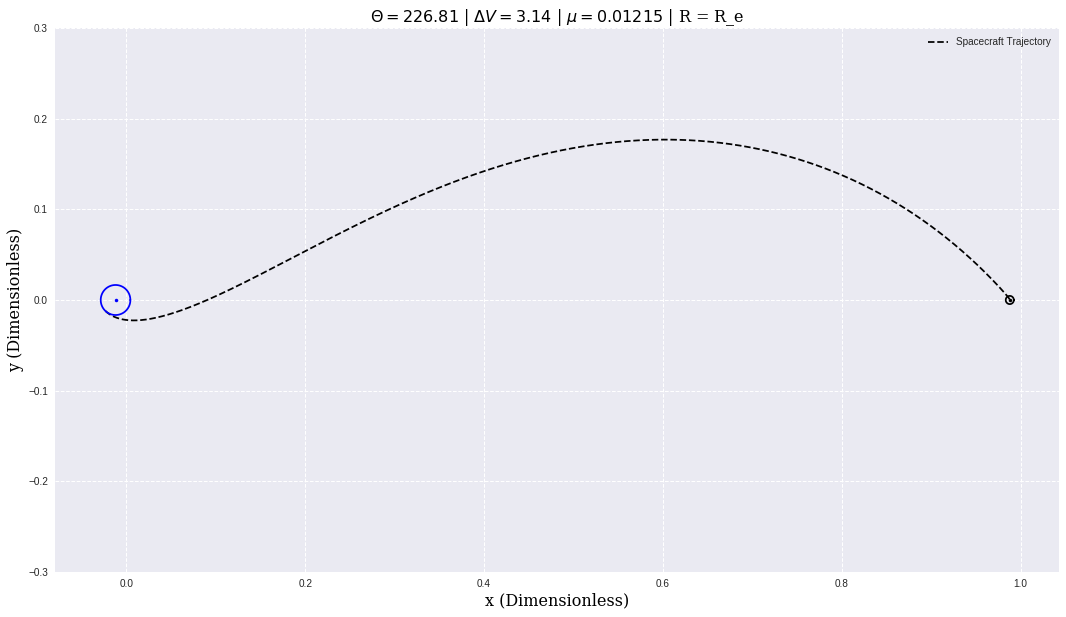

In [23]:
phi = np.linspace(0,2*np.pi,100)
plt.figure(figsize=(18,10))
plt.title("$\Theta = 226.81$ | $\Delta V = 3.14$ | $\mu = 0.01215$ | R = R_e", fontdict=font)
plt.xlabel("x (Dimensionless)", fontdict=font)
plt.ylabel("y (Dimensionless)",fontdict=font)
plt.plot(x_array, y_array, 'k--', label = 'Spacecraft Trajectory')
plt.plot(R_Earth*np.cos(phi)-reduced_mass,R_Earth*np.sin(phi),'b-',-mu,0, 'b.')
plt.plot(R_Moon*np.cos(phi)+(1-reduced_mass),R_Moon*np.sin(phi), 'k-',(1-mu),0, 'k.')
plt.grid(linestyle = '--')
plt.ylim(-0.3,0.3)
plt.legend()

Next, we plot a few key quantities, one of which is the craft's net displacement from Earth at time $t$.

Text(0,0.5,'Displacement')

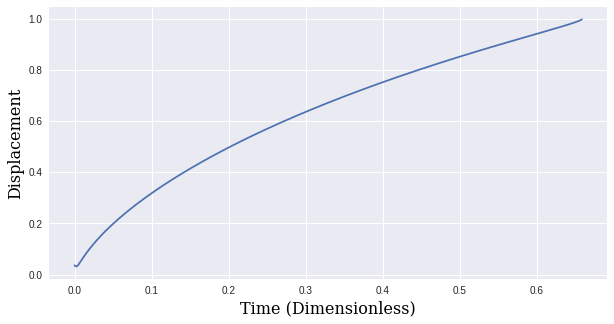

In [24]:
plt.figure(figsize=(10,5))
plt.plot(time_array, np.sqrt(np.asarray(x_array)**2+np.asarray(y_array)**2) +0.01)
plt.xlabel("Time (Dimensionless)", fontdict = font)
plt.ylabel("Displacement", fontdict = font)

Looks about right. Let's see how we're doing with energy conservation.

Text(0,0.5,'Energy (Dimensionless)')

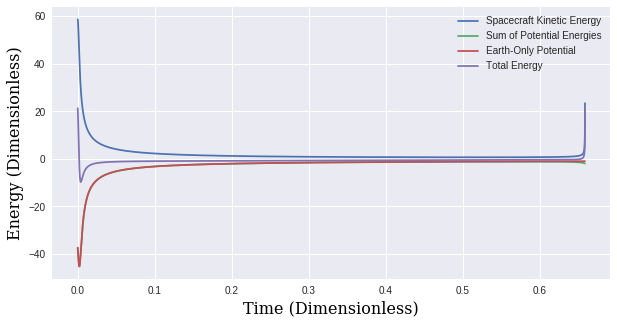

In [25]:
plt.figure(figsize=(10,5))
plt.plot(time_array, 1.0/2.0 * np.sqrt(np.asarray(vx_array)**2 + np.asarray(vy_array)**2)**2, label = 'Spacecraft Kinetic Energy') #ke
plt.plot(time_array, -(earth_mass/total_mass) / np.sqrt((np.asarray(x_array))**2 + (np.asarray(y_array)**2))-(moon_mass/total_mass) / np.sqrt((1.0 - np.asarray(x_array))**2 + (np.asarray(y_array)**2)), label = 'Sum of Potential Energies')
plt.plot(time_array, -(earth_mass/total_mass) / np.sqrt((np.asarray(x_array))**2 + (np.asarray(y_array)**2)), label = 'Earth-Only Potential')
plt.plot(time_array, 1.0/2.0 * np.sqrt(np.asarray(vx_array)**2 + np.asarray(vy_array)**2)**2-(earth_mass/total_mass) / np.sqrt((np.asarray(x_array))**2 + (np.asarray(y_array)**2))-(moon_mass/total_mass) / np.sqrt((1.0 - np.asarray(x_array))**2 + (np.asarray(y_array)**2)), label = 'Total Energy')
plt.legend()
plt.xlabel("Time (Dimensionless)", fontdict = font)
plt.ylabel("Energy (Dimensionless)", fontdict = font)

Naively, this should be unexpected; the total energy in this system should be constant. Let's take a closer look at the energies and see if we can identify any interesting patterns.

Text(0,0.5,'Velocity (Dimensionless)')

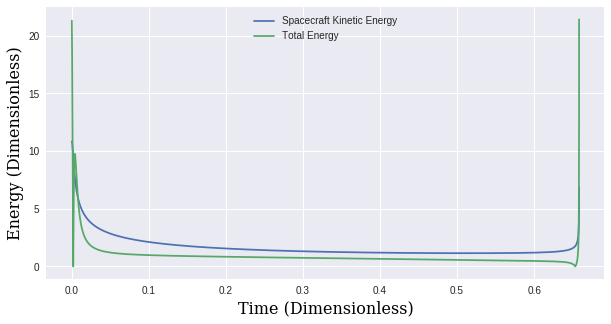

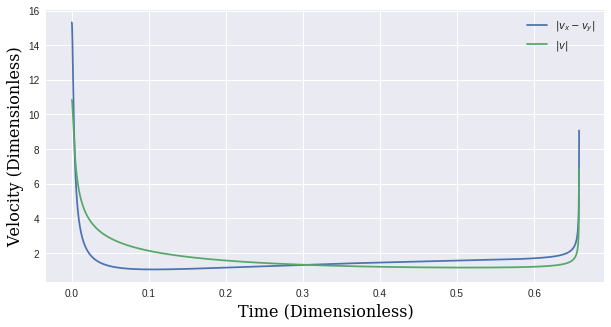

In [26]:
plt.figure(figsize=(10,5))
plt.plot(time_array, np.sqrt(np.asarray(vx_array)**2 + np.asarray(vy_array)**2), label = 'Spacecraft Kinetic Energy') #ke
plt.plot(time_array, np.abs(1.0/2.0 * np.sqrt(np.asarray(vx_array)**2 + np.asarray(vy_array)**2)**2-(earth_mass/total_mass) / np.sqrt((np.asarray(x_array))**2 + (np.asarray(y_array)**2))-(moon_mass/total_mass) / np.sqrt((1.0 - np.asarray(x_array))**2 + (np.asarray(y_array)**2))), label = 'Total Energy')
plt.xlabel("Time (Dimensionless)", fontdict = font)
plt.ylabel("Energy (Dimensionless)", fontdict = font)
plt.legend()
plt.figure(figsize=(10,5))
plt.plot(time_array, np.abs((np.asarray(vx_array) - np.asarray(vy_array))), label = '$| v_x - v_y |$')
plt.plot(time_array, np.sqrt(np.asarray(vx_array)**2 + np.asarray(vy_array)**2), label = '$|v|$') #ke
plt.legend()
plt.xlabel("Time (Dimensionless)", fontdict = font)
plt.ylabel("Velocity (Dimensionless)", fontdict = font)


Interesting -- the system appears to gain the most energy when the most drastic changes in velocity take place.

In the next notebook, we will perform a similar analysis on free-return Earth-Moon cycler orbits, and perhaps, get to the bottom of our anomalous energy conservation issues.